Задача: Разработать/доработать контурную LLM, которая выявляет в диалогах (текстовых) токсичные фразы (негативный оттенок, оскорбления, бранные слова), а также признаки перебивания.

Действия:
1. Определиться с входным форматом данных.
2. Выгрузить из различных чатов в телеграм диалоги и написать скрипт для преобразования телеграм диалогов в выбранный формат
3. Посмотреть готовые модели  и датасеты на HuggingFace по ключевому слову toxic.
4. Выбрать модель. Понять нужно ли её дообучать? Выбрать метод обучения. Если надо дообучить.
5. Запустить модель для инференса (квантование, шардинг) на CPU.
6. Проверить модель на данных из телеграм
7. Предложить варианты оптимизации.
8. Параллельно держим в голове, как определить перебивания в текстовых диалогах, высказываем предположения, проверяем предположения.
9. Прикрутить внешний словарь токсичных слов, что пользователь считает токсичностью. Например, что не этично в рамках культурных ценностей компании или отдельные слова, фразы.

Если вы используете параметр `useTinkoff`, то данные беруться из голосового файла, иначе загружается пример из гугл диска.

In [ ]:
useTinkoff = False

# Установка необходимых библиотек

In [ ]:
if useTinkoff:
    !pip install tinkoff-voicekit-client protobuf==3.20.3
    !pip install pydub
    from tinkoff_voicekit_client import ClientSTT
    from pydub import AudioSegment

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

!pip uninstall pyarrow requests -y
!pip install requests==2.31.0 pyarrow==14.0.1
!pip install accelerate bitsandbytes
!pip install sentence-transformers
!pip install optimum[onnxruntime]

from sentence_transformers import SentenceTransformer
import json
import pandas as pd
from optimum.onnxruntime import ORTModelForSequenceClassification, ORTModelForTokenClassification
from optimum.pipelines import pipeline
from torch import device
from transformers import AutoTokenizer
from huggingface_hub import login
from datetime import timedelta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 9.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of grpcio-tools to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 42.6 MB/s eta 0:00:00
     ━━━

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Парсинг аудио

In [ ]:
if useTinkoff:
    # загрузим голосовой файл
    !wget https://storage.yandexcloud.net/academy.ai/test/bank.mp3

    API_KEY = '------------='
    SECRET_KEY = '---------------='

    file_path = "./bank.mp3"
    cut_file = "./cut.mp3"

    music = AudioSegment.from_file(file=file_path, format='mp3')
    print("Продолжительность аудио, сек:", music.duration_seconds)
    print("Частота дискретизации:", music.frame_rate)
    print("Количество каналов:", music.channels)

    # если нужен фрагмент
    # представление 22 минуты в миллисекундах
    start_to_cut = 200 * 1000

    end_to_cut = 300 * 1000
    # обрезка файла при помощи индексации music[time_to_cut:]
    # сохраним фрагмент в файл с заданной миллисекунды
    music[start_to_cut:end_to_cut].export(cut_file, format='mp3')

    audio_config = {"encoding": "MPEG_AUDIO",
                    "sample_rate_hertz": music.frame_rate,
                    "num_channels": music.channels}


    client = ClientSTT(API_KEY, SECRET_KEY)

    response = client.recognize(cut_file, audio_config)

    del API_KEY, SECRET_KEY, file_path, cut_file, music, start_to_cut, \
    end_to_cut, audio_config, client

--2024-07-08 03:50:50--  https://storage.yandexcloud.net/academy.ai/test/bank.mp3
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77090925 (74M) [audio/mpeg]
Saving to: ‘bank.mp3’

bank.mp3            100%[===================>]  73.52M  14.7MB/s    in 6.3s    

2024-07-08 03:50:57 (11.7 MB/s) - ‘bank.mp3’ saved [77090925/77090925]

Продолжительность аудио, сек: 1927.2098125
Частота дискретизации: 48000
Количество каналов: 2


# Создание датафрейма

Если вы используете параметр `useTinkoff`, то данные беруться из голосового файла, иначе загружается пример из гугл диска.

In [ ]:
if not useTinkoff:
  try:
      # Попытка обратиться к переменной
      response
  except NameError:
      # Если переменная не существует, выполняется этот код
      !gdown --id "16qf3j8j6fAzBCuxkmLYnWtF-_kD6eN1v"
      with open("result.json", 'r', encoding='utf-8') as file:
          response = json.load(file)

rows = []

# Обработка каждого элемента в results
for item in response['results']:
  user = 'Сторона 1' if item['channel'] == 0 else 'Сторона 2'
  start_time = item['start_time'].rstrip('s')
  end_time = item['end_time'].rstrip('s')
  text = item['alternatives'][0]['transcript']

  rows.append({
      'user': user,
      'start_time': float(start_time),
      'end_time': float(end_time),
      'text': text
  })

df = pd.DataFrame(rows) \
    .sort_values('start_time') \
    .reset_index(drop=True)

df['toxicity'] = False
df['toxic_words'] = ''
df['interruption'] = False

df['add_words'] = ''
df['add_words_similarity'] = ''
df['add_words_index'] = ''

# Авторизация HuggingFace

In [ ]:
login("------------")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


# Запуск Классификатора

In [ ]:
# Выбор модели
model_id = "khvatov/ru_toxicity_detector"

# Экспортирую модель в ONNX
classifier_model = ORTModelForSequenceClassification.from_pretrained(model_id, export=True, from_transformers=True)
# Необходимо использовать CPU
classifier_model.to(device('cpu'))
# Загружаю токенизатор
classifier_tokenizer = AutoTokenizer.from_pretrained(model_id)

classifier = pipeline(task="text-classification", model=classifier_model, tokenizer=classifier_tokenizer, accelerator="ort")
del classifier_model, classifier_tokenizer

The argument `from_transformers` is deprecated, and will be removed in optimum 2.0.  Use `export` instead
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

Framework not specified. Using pt to export the model.


model.safetensors:   0%|          | 0.00/117M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Using the export variant default. Available variants are:
    - default: The default ONNX variant.

***** Exporting submodel 1/1: BertForSequenceClassification *****
Using framework PyTorch: 2.3.0+cu121
Overriding 1 configuration item(s)
	- use_cache -> False


In [ ]:
# Функция для оценки токсичности сообщений
def evaluate_toxicity(text):
    result = classifier(text)[0]
    return result['score'] if result['label'] == 'LABEL_1' else 1 - result['score'] # если токсичный лейбл, то выводим скор, если нет, то вычетаем скор из нетоксичного лейбла

# Применение функции ко всем сообщениям
df['toxicity_score'] = df['text'].apply(evaluate_toxicity)
df['toxicity'] = df['toxicity_score'] > 0.6 # по идее можно и 0.5

# Отображение обновленного DataFrame
df

,user,start_time,end_time,text,toxicity,toxic_words,interruption,add_words,add_words_similarity,add_words_index,toxicity_score
0,Сторона 1,0.93,1.41,пока пока,False,,False,,,,0.001976
1,Сторона 2,0.93,1.41,пока пока,False,,False,,,,0.001976
2,Сторона 1,2.49,3.78,пока сухари передам вам,True,,False,,,,0.956303
3,Сторона 2,2.49,3.78,пока сухари передам вам,True,,False,,,,0.956303
4,Сторона 1,7.26,7.32,да,False,,False,,,,0.003677
5,Сторона 2,7.26,7.32,да,False,,False,,,,0.003677
6,Сторона 1,10.41,11.55,здравствуйте да да,False,,False,,,,0.000321
7,Сторона 2,10.41,11.55,здравствуйте да да,False,,False,,,,0.000321
8,Сторона 2,13.59,22.26,меня зовут мочалова ирина андреевна за вас спе...,False,,False,,,,0.003416
9,Сторона 1,13.59,22.26,меня зовут мочалова ирина андреевна да вам спе...,False,,False,,,,0.002794


# Запуск Фломастера

In [ ]:
model_id = "IlyaGusev/rubertconv_toxic_editor"

# Экспортирую модель в ONNX
editor_model = ORTModelForTokenClassification.from_pretrained(model_id, export=True, from_transformers=True)
editor_tokenizer = AutoTokenizer.from_pretrained(model_id)
editor_model.to(device('cpu'))

editor = pipeline(
    "token-classification",
    model=editor_model,
    tokenizer=editor_tokenizer,
    framework="pt",
    device=-1,
    aggregation_strategy="max",
    accelerator="ort"
)

del editor_model, editor_tokenizer

The argument `from_transformers` is deprecated, and will be removed in optimum 2.0.  Use `export` instead
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

Framework not specified. Using pt to export the model.


pytorch_model.bin:   0%|          | 0.00/709M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.20M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Using the export variant default. Available variants are:
    - default: The default ONNX variant.

***** Exporting submodel 1/1: BertForTokenClassification *****
Using framework PyTorch: 2.3.0+cu121
Overriding 1 configuration item(s)
	- use_cache -> False


# Применение Фломастера

In [ ]:
# Функция для поиска токсичных слов
def search_toxic(text):
    toxic_words = []
    prediction = editor(text, batch_size=1)
    for row in prediction:
        if row['entity_group'] == 'delete' or row['entity_group'] == 'replace':
            toxic_words.append(row['word'])
    return ', '.join(toxic_words)  # Объединяем слова в строку, разделенную запятыми

# Применение функции ко всем сообщениям с toxicity == True
df['toxic_words'] = df.apply(lambda row: search_toxic(row['text']) if row['toxicity'] else '', axis=1)

df

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


,user,start_time,end_time,text,toxicity,toxic_words,interruption,add_words,add_words_similarity,add_words_index,toxicity_score
0,Сторона 1,0.93,1.41,пока пока,False,,False,,,,0.001976
1,Сторона 2,0.93,1.41,пока пока,False,,False,,,,0.001976
2,Сторона 1,2.49,3.78,пока сухари передам вам,True,,False,,,,0.956303
3,Сторона 2,2.49,3.78,пока сухари передам вам,True,,False,,,,0.956303
4,Сторона 1,7.26,7.32,да,False,,False,,,,0.003677
5,Сторона 2,7.26,7.32,да,False,,False,,,,0.003677
6,Сторона 1,10.41,11.55,здравствуйте да да,False,,False,,,,0.000321
7,Сторона 2,10.41,11.55,здравствуйте да да,False,,False,,,,0.000321
8,Сторона 2,13.59,22.26,меня зовут мочалова ирина андреевна за вас спе...,False,,False,,,,0.003416
9,Сторона 1,13.59,22.26,меня зовут мочалова ирина андреевна да вам спе...,False,,False,,,,0.002794


# Классификация на перебивание

In [ ]:
# Функция для преобразования строковых временных меток в timedelta
def convert_to_timedelta(time_str):
    return timedelta(seconds=time_str)

# Преобразуем временные метки в timedelta
df['start_time_dt'] = df['start_time'].apply(convert_to_timedelta)
df['end_time_dt'] = df['end_time'].apply(convert_to_timedelta)

# Препроцессинг текста (удаление пунктуации, приведение к нижнему регистру, и т.д.)
def preprocess_text(text):
    import re
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip().split()

# Функция для проверки схожести тем по косинусному сходству и коэффициенту Жаккара
def is_same_topic(text1, text2, threshold_cosine, threshold_jaccard):
    # Проверка косинусного сходства
    vectorizer = TfidfVectorizer().fit_transform([text1, text2])
    vectors = vectorizer.toarray()
    cosine_sim = cosine_similarity([vectors[0]], [vectors[1]])[0][0]

    # Проверка коэффициента Жаккара
    words1 = set(preprocess_text(text1))
    words2 = set(preprocess_text(text2))
    jaccard_sim = len(words1.intersection(words2)) / len(words1.union(words2))

    # Проверка на соответствие хотя бы одному из пороговых значений
    return cosine_sim >= threshold_cosine or jaccard_sim >= threshold_jaccard

# Функция для проверки, является ли фраза незаконченной
def is_unfinished_phrase(text):
    # Список слов, которые могут указывать на незаконченную фразу
    unfinished_words = ['и', 'но', 'а', 'или', 'что', 'чтобы', 'если', 'потому', 'поэтому', 'так', 'как', 'когда', 'где', 'куда', 'откуда', 'в', 'на', 'под', 'над', 'за', 'перед', 'около']
    words = text.strip().split()
    last_word = words[-1]
    # Проверяем, заканчивается ли фраза на слово из списка
    if last_word in unfinished_words:
        return True
    # Считаем короткие фразы потенциально незаконченными
    if len(words) < 5:
        return True
    return False

# Функция для определения перебивания
def is_interruption(current_row, previous_row, time_threshold=0.5, length_threshold=5, topic_threshold_cosine=0.001, topic_threshold_jaccard=0.3):
    # Вычисляем разницу во времени между текущей и предыдущей репликой
    time_diff = (current_row['start_time_dt'] - previous_row['end_time_dt']).total_seconds()
    # Проверяем условия перебивания
    if time_diff <= time_threshold and current_row['user'] != previous_row['user']:
        # Проверка на короткую реплику
        if len(current_row['text'].split()) <= length_threshold:
            return True
        # Проверка на смену темы
        if not is_same_topic(current_row['text'], previous_row['text'], topic_threshold_cosine, topic_threshold_jaccard):
            return True
        # Проверка на незаконченность предыдущей фразы
        if is_unfinished_phrase(previous_row['text']):
            return True
    return False

# Поиск перебиваний в диалоге и обновление DataFrame
for i in range(1, len(df)):
    current_row = df.iloc[i]
    previous_row = df.iloc[i - 1]
    if is_interruption(current_row, previous_row):
        df.at[i, 'interruption'] = True

df = df.drop(['start_time_dt','end_time_dt'], axis=1)

df[df["interruption"]== True]

,user,start_time,end_time,text,toxicity,toxic_words,interruption,add_words,add_words_similarity,add_words_index,toxicity_score
1,Сторона 2,0.93,1.41,пока пока,False,,True,,,,0.001976
3,Сторона 2,2.49,3.78,пока сухари передам вам,True,,True,,,,0.956303
5,Сторона 2,7.26,7.32,да,False,,True,,,,0.003677
7,Сторона 2,10.41,11.55,здравствуйте да да,False,,True,,,,0.000321
21,Сторона 2,65.76,66.60,острый наступил,False,,True,,,,0.001439
29,Сторона 1,91.56,93.03,вы вообще ответов слышите,False,,True,,,,0.000925
33,Сторона 1,99.51,100.38,нет,False,,True,,,,0.001530


# Поиск дополнительных слов

In [ ]:
# Модель Эмбеддинга
# https://www.sbert.net/docs/pretrained_models.html
# model_name = 'sentence-transformers/all-mpnet-base-v2'
model_name = 'cointegrated/LaBSE-en-ru'
model = SentenceTransformer(model_name)

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/516M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/521k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

In [ ]:
documents = df['text'].tolist()

documents

['пока пока',
 'пока пока',
 'пока сухари передам вам',
 'пока сухари передам вам',
 'да',
 'да',
 'здравствуйте да да',
 'здравствуйте да да',
 'меня зовут мочалова ирина андреевна за вас специалист департамента взыскания просроченной задолженности альфа банк информирую о записи разговора наталья николаевна с вами разговариваю да да',
 'меня зовут мочалова ирина андреевна да вам специалист департамента взыскания просроченной задолженности альфа банк информирую о записи разговора наталья николаевна с вами разговариваю да да',
 'вот имеется задолженность сто тридцать пять тысяч восемьдесят четыре рубля',
 'вот имеется задолженность сто тридцать пять тысяч восемьдесят четыре рубля',
 'по второму договору у вас сумма составляет сто двадцать девять тысяч восемьдесят девять рублей необходимо в течение двух дней внести оплату',
 'по второму договору у вас сумма составляет сто двадцать девять тысяч восемьдесят девять рублей необходимо в течение двух дней внести оплату',
 'вопрос вами как реша

In [ ]:
# Поиск слов в каждом документе
def search_words(query, documents, threshold=0.8):
    for row, doc in enumerate(documents):
        args_threshold = []

        # Делим документ на слова
        words = doc.split()

        # Получение векторных представлений для запроса и документов
        document_embeddings = model.encode(words)
        query_embeddings = model.encode(query)

        # Вычисление косинусного сходства между каждым словом запроса и каждым документом
        for query_emb in query_embeddings:
            for i, doc_emb in enumerate(document_embeddings):
                similarity = cosine_similarity([query_emb], [doc_emb])[0][0]
                if similarity >= threshold:
                    args_threshold.append((str(i), str(round(similarity, 4)), words[i]))

        words = ', '.join(i[2] for i in args_threshold if i)
        similarity = ', '.join(i[1] for i in args_threshold if i)
        indx = ', '.join(i[0] for i in args_threshold if i)

        if args_threshold:
            df.at[row, 'add_words'] = words
            df.at[row, 'add_words_similarity'] = similarity
            df.at[row, 'add_words_index'] = indx

        print(f"\nЗапрос: '{query}'")
        print(f"Где ищем: '{doc}'\n")

        if words:
            print(f"Найдено похожих слов:")
            print(f"'{words}', индекс: {indx}, косинусное сходство: {similarity}")
        else:
            print('Похожих слов не найдено')

        print('*'*150)

In [ ]:
# Поисковый запрос
query = ['money',
         'звонишь',
         'phone',
         'сопляк',
         'scream',
         'office']

# Запуск поиска слов в документах
search_words(query, documents, threshold=0.8)


Запрос: '['money', 'звонишь', 'phone', 'сопляк', 'scream', 'office']'
Где ищем: 'пока пока'

Похожих слов не найдено
******************************************************************************************************************************************************

Запрос: '['money', 'звонишь', 'phone', 'сопляк', 'scream', 'office']'
Где ищем: 'пока пока'

Похожих слов не найдено
******************************************************************************************************************************************************

Запрос: '['money', 'звонишь', 'phone', 'сопляк', 'scream', 'office']'
Где ищем: 'пока сухари передам вам'

Похожих слов не найдено
******************************************************************************************************************************************************

Запрос: '['money', 'звонишь', 'phone', 'сопляк', 'scream', 'office']'
Где ищем: 'пока сухари передам вам'

Похожих слов не найдено
***********************************************

In [ ]:
df

,user,start_time,end_time,text,toxicity,toxic_words,interruption,add_words,add_words_similarity,add_words_index,toxicity_score
0,Сторона 1,0.93,1.41,пока пока,False,,False,,,,0.001976
1,Сторона 2,0.93,1.41,пока пока,False,,True,,,,0.001976
2,Сторона 1,2.49,3.78,пока сухари передам вам,True,,False,,,,0.956303
3,Сторона 2,2.49,3.78,пока сухари передам вам,True,,True,,,,0.956303
4,Сторона 1,7.26,7.32,да,False,,False,,,,0.003677
5,Сторона 2,7.26,7.32,да,False,,True,,,,0.003677
6,Сторона 1,10.41,11.55,здравствуйте да да,False,,False,,,,0.000321
7,Сторона 2,10.41,11.55,здравствуйте да да,False,,True,,,,0.000321
8,Сторона 2,13.59,22.26,меня зовут мочалова ирина андреевна за вас спе...,False,,False,,,,0.003416
9,Сторона 1,13.59,22.26,меня зовут мочалова ирина андреевна да вам спе...,False,,False,,,,0.002794


# Статистика

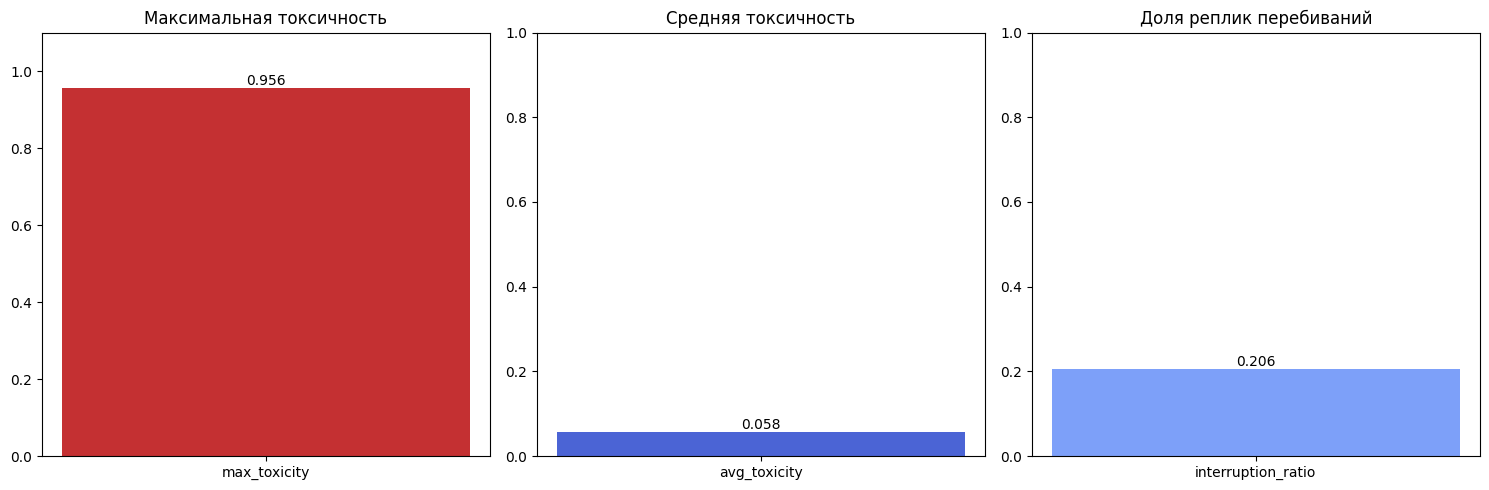

Максимальная токсичность: 0.956
Средняя токсичность: 0.058
Доля реплик перебиваний: 0.206


In [ ]:
import matplotlib.pyplot as plt

def calculate_and_visualize_metrics(df):
    # 1. Максимальная токсичность
    max_toxicity = df['toxicity_score'].max()

    # 2. Средняя токсичность
    avg_toxicity = df['toxicity_score'].mean()

    # 3. Доля реплик перебиваний
    interruption_ratio = df['interruption'].sum() / len(df)

    # Создаем функцию для определения цвета
    def get_color(value):
        return plt.cm.coolwarm(value)

    # Создаем график
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Максимальная токсичность
    ax1.bar(["max_toxicity"], [max_toxicity], color=get_color(max_toxicity))
    ax1.set_ylim(0, 1.1)  # Увеличиваем верхний предел
    ax1.set_title("Максимальная токсичность")
    ax1.text(0, max_toxicity, f'{max_toxicity:.3f}', ha='center', va='bottom')

    # Средняя токсичность
    ax2.bar(["avg_toxicity"], [avg_toxicity], color=get_color(avg_toxicity))
    ax2.set_ylim(0, 1)
    ax2.set_title("Средняя токсичность")
    ax2.text(0, avg_toxicity, f'{avg_toxicity:.3f}', ha='center', va='bottom')

    # Доля реплик перебиваний
    ax3.bar(["interruption_ratio"], [interruption_ratio], color=get_color(interruption_ratio))
    ax3.set_ylim(0, 1)
    ax3.set_title("Доля реплик перебиваний")
    ax3.text(0, interruption_ratio, f'{interruption_ratio:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    return max_toxicity, avg_toxicity, interruption_ratio


max_tox, avg_tox, int_ratio = calculate_and_visualize_metrics(df)
print(f"Максимальная токсичность: {max_tox:.3f}")
print(f"Средняя токсичность: {avg_tox:.3f}")
print(f"Доля реплик перебиваний: {int_ratio:.3f}")

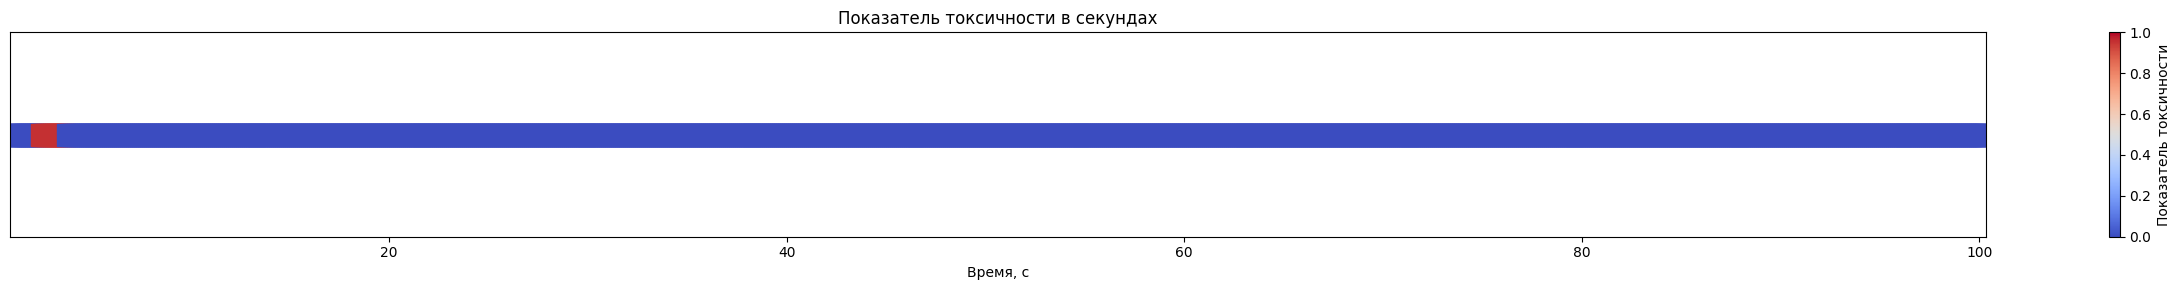

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def create_toxicity_heatmap(df):
    # Сортируем DataFrame по времени начала реплики
    df_sorted = df.sort_values('start_time')

    # Создаем массив времени с шагом в 0.1 секунды
    time_range = np.arange(df_sorted['start_time'].min(), df_sorted['end_time'].max(), 0.1)

    # Создаем массив toxicity_score для каждого момента времени
    toxicity_values = np.zeros_like(time_range)

    for _, row in df_sorted.iterrows():
        start_idx = np.searchsorted(time_range, row['start_time'])
        end_idx = np.searchsorted(time_range, row['end_time'])
        toxicity_values[start_idx:end_idx] = row['toxicity_score']

    # Создаем график
    fig, ax = plt.subplots(figsize=(25, 3))

    # Создаем scatter plot с цветовой кодировкой
    scatter = ax.scatter(time_range, np.ones_like(time_range), c=toxicity_values,
                         cmap='coolwarm', vmin=0, vmax=1, s=250, marker='s')


    # Настраиваем оси
    ax.set_xlim(time_range.min(), time_range.max())
    ax.set_ylim(0.9, 1.1)
    ax.set_yticks([])  # Убираем метки по оси y

    # Добавляем заголовок и подписи осей
    ax.set_title('Показатель токсичности в секундах')
    ax.set_xlabel('Время, с')

    # Добавляем цветовую шкалу
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Показатель токсичности')

    plt.tight_layout()
    plt.show()

# Используем функцию
create_toxicity_heatmap(df)

In [ ]:
df.head(100)

,user,start_time,end_time,text,toxicity,toxic_words,interruption,add_words,add_words_similarity,add_words_index,toxicity_score
0,Сторона 1,0.93,1.41,пока пока,False,,False,,,,0.001976
1,Сторона 2,0.93,1.41,пока пока,False,,True,,,,0.001976
2,Сторона 1,2.49,3.78,пока сухари передам вам,True,,False,,,,0.956303
3,Сторона 2,2.49,3.78,пока сухари передам вам,True,,True,,,,0.956303
4,Сторона 1,7.26,7.32,да,False,,False,,,,0.003677
5,Сторона 2,7.26,7.32,да,False,,True,,,,0.003677
6,Сторона 1,10.41,11.55,здравствуйте да да,False,,False,,,,0.000321
7,Сторона 2,10.41,11.55,здравствуйте да да,False,,True,,,,0.000321
8,Сторона 2,13.59,22.26,меня зовут мочалова ирина андреевна за вас спе...,False,,False,,,,0.003416
9,Сторона 1,13.59,22.26,меня зовут мочалова ирина андреевна да вам спе...,False,,False,,,,0.002794
